# Classifying Images

## Working with a Set of Images

In [1]:
if (!require("png")) {install.packages("png")
                      library("png")}

Loading required package: png



__NOTE:__ Don't import the file using `native=TRUE` with `readPNG()` or you'll encounter problems working with it later.

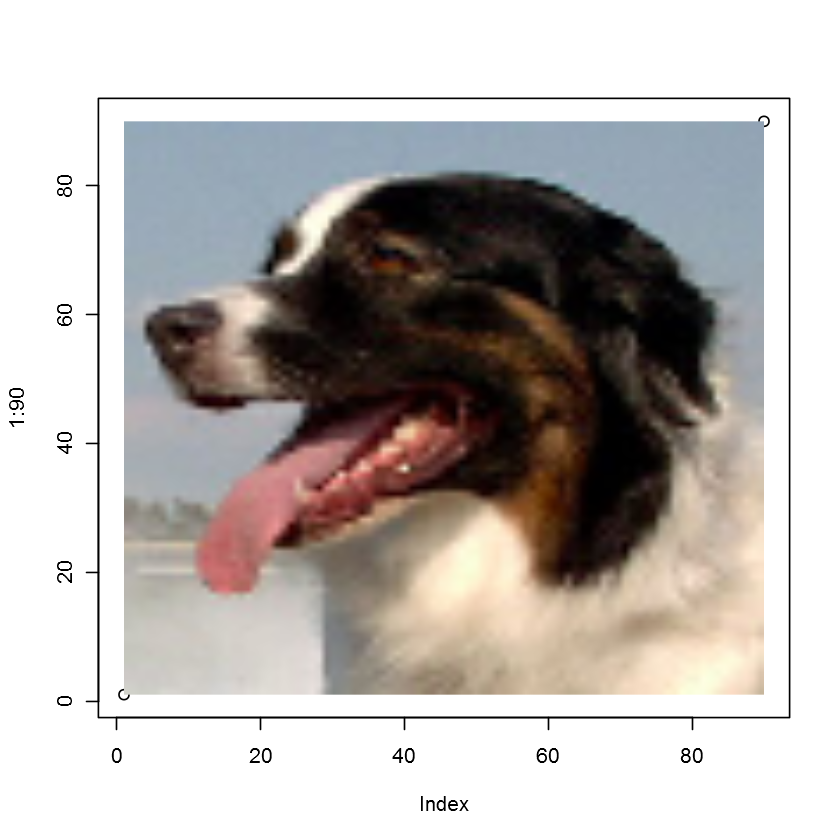

In [2]:
download.file(url="https://upload.wikimedia.org/wikipedia/commons/7/7d/Dog_face.png",
              destfile = "Dog_face.png", mode='wb')
image <- readPNG("Dog_face.png")
plot(1:90)
rasterImage(image, 1, 1, 90, 90)

The `imager` library is based on `CImg`, but it's easier to use. You can find the documentation for it at https://rdrr.io/cran/imager/man/. The first step in working with the image loaded in the previous step is to convert it to a `CImg`, then modify it to grayscale. The warning message is normal.

In [3]:
if (!require("imager")) {install.packages("imager")
                         library("imager")}

Loading required package: imager

Warning message:
"package 'imager' was built under R version 4.0.3"
Loading required package: magrittr


Attaching package: 'imager'


The following object is masked from 'package:magrittr':

    add


The following objects are masked from 'package:stats':

    convolve, spectrum


The following object is masked from 'package:graphics':

    frame


The following object is masked from 'package:base':

    save.image




Warning message in as.cimg.array(image, x = 90, y = 90, cc = 3):
"Assuming third dimension corresponds to colour"


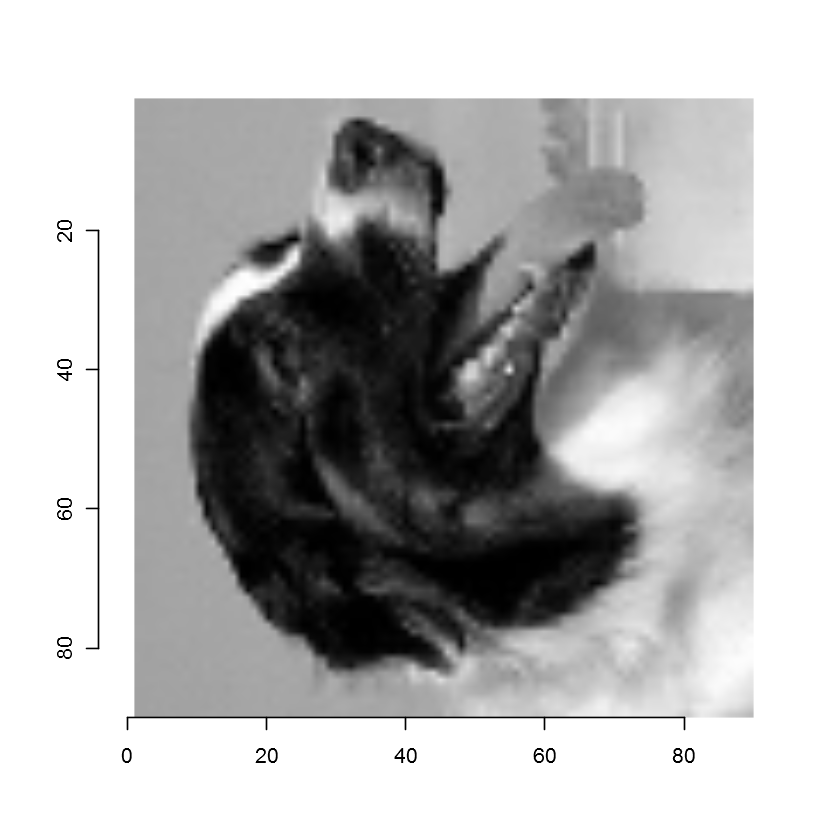

In [4]:
gs_image <- grayscale(as.cimg(image, x=90, y=90, cc=3))
plot(gs_image)

In order to make the image look like the color version, we need to rotate and flip it. This is due to the conversion process. The `imager` library doesn't come with a flip function, so you must perform the task by reversing the bits in the image as shown in the second line below.

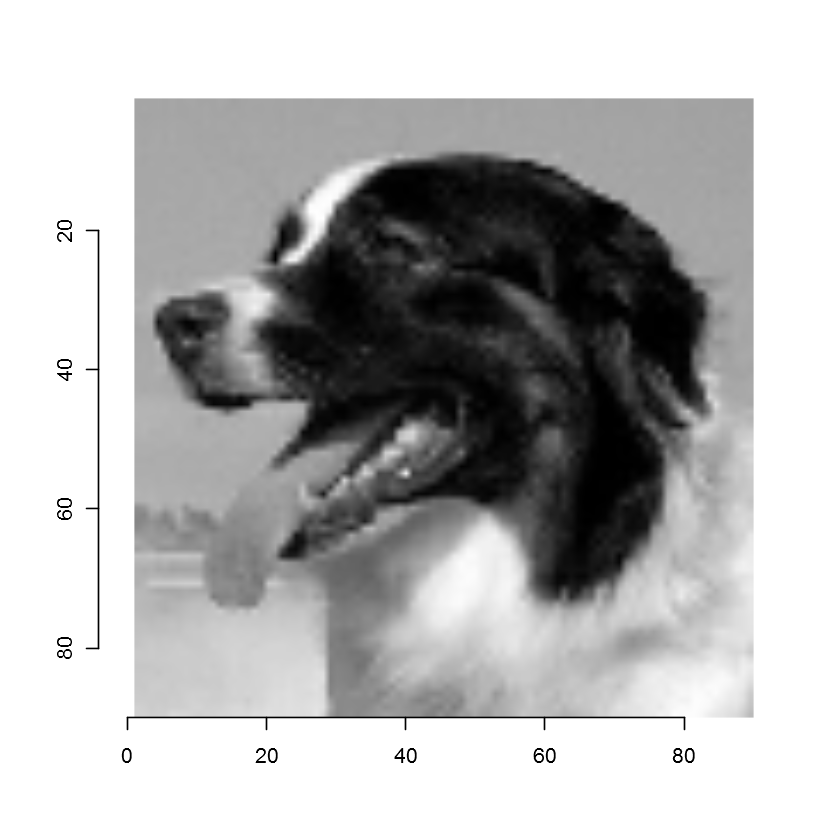

In [5]:
gs_image2 <- rotate_xy(gs_image, 90, 44.5, 44.5)
gs_image2 <- as.cimg(apply(as.matrix(gs_image2), 2, rev))
plot(gs_image2)

Filtering, cropping, sizing, and flattening the image comes next.

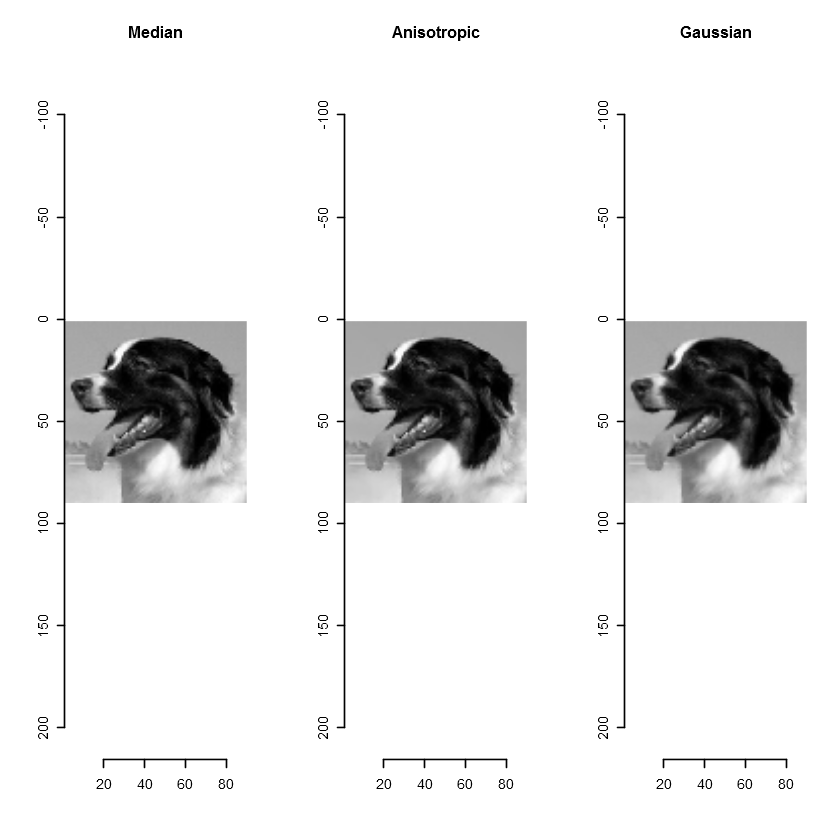

In [6]:
gaussian <- isoblur(gs_image2, .5, neumann = TRUE, gaussian = TRUE)
anisotropic <- blur_anisotropic(gs_image2, ampl=5, sharp=1)
median <- medianblur(gs_image2, .5)

par(mfrow=c(1,3))
plot(median, main="Median")
plot(anisotropic, main="Anisotropic")
plot(gaussian, main="Gaussian")

In [7]:
print(attributes(median))

$class
[1] "cimg"         "imager_array" "numeric"     

$dim
[1] 90 90  1  1



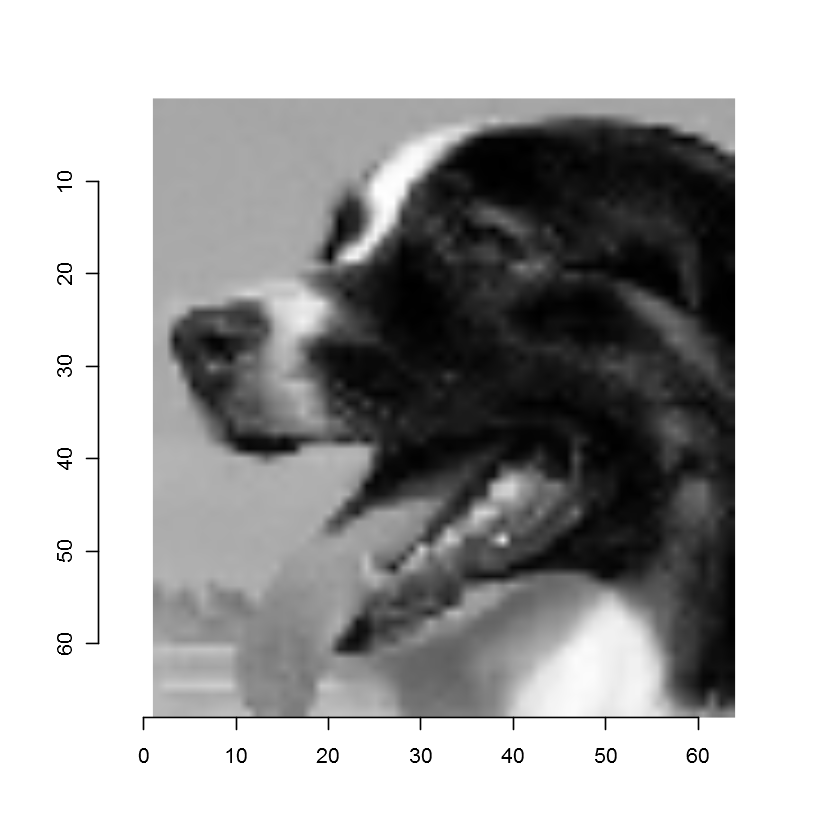

In [8]:
gs_image3 <- as.cimg(median[2:65, 7:74])
plot(gs_image3)

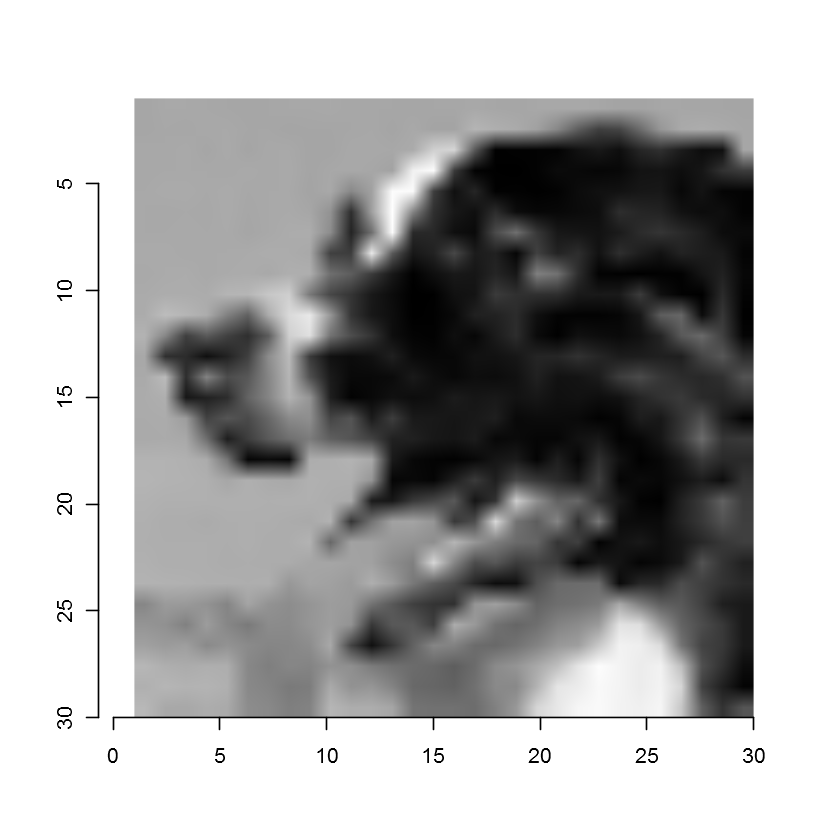

In [9]:
gs_image4 <- resize(gs_image3, size_x=30, size_y=30)
plot(gs_image4)

In [10]:
if (!require("reshape")) {install.packages("reshape")
                          library("reshape")}

Loading required package: reshape

Warning message:
"package 'reshape' was built under R version 4.0.3"


In [11]:
library(reshape)

image_row <- gs_image4
dim(image_row) <- c(1, 900)
print(attributes(image_row))

$class
[1] "cimg"         "imager_array" "numeric"     

$dim
[1]   1 900



## Extracting Visual Features

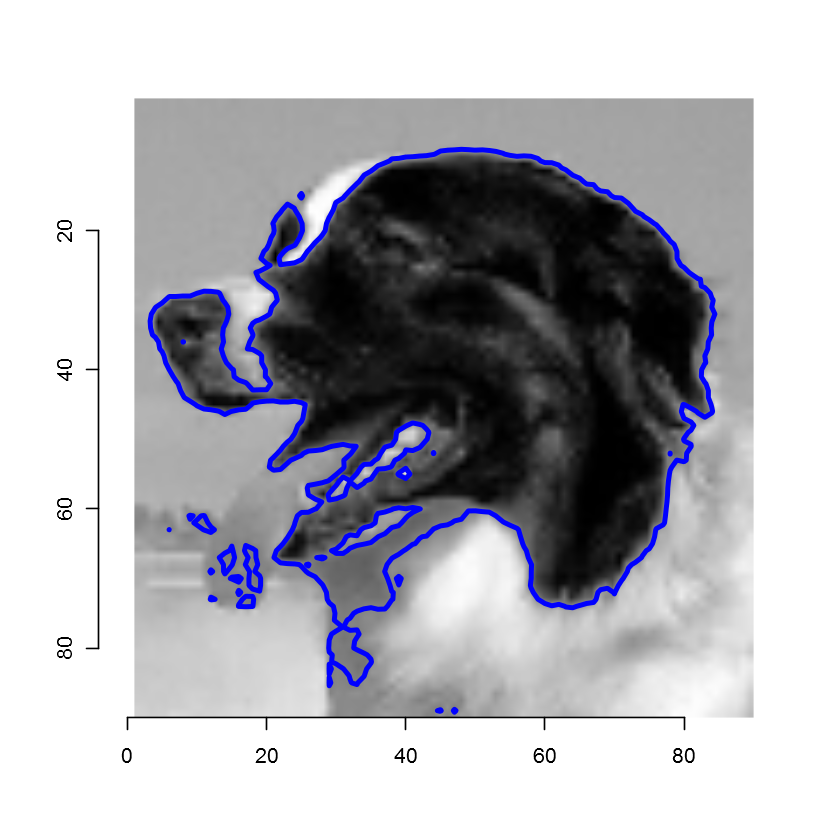

In [12]:
ct <- contours(gs_image2, nlevels=3)
plot(gs_image2)
purrr::walk(ct,function(v) lines(v$x,v$y,col="blue",lwd=3))

## Recognizing Faces Using Eigenfaces

In [13]:
# Obtain the X features.
if (!file.exists("olivetti_X.csv")){
    download.file(url="https://raw.githubusercontent.com/rajsiddarth/Datasets/master/olivetti_X.csv",
              destfile = "olivetti_X.csv", mode='wb')}
X_df <- read.csv("olivetti_X.csv", header=FALSE)

# Obtain the y labels.
if (!file.exists("olivetti_y.csv")){
    download.file(url="https://raw.githubusercontent.com/rajsiddarth/Datasets/master/olivetti_y.csv",
              destfile = "olivetti_y.csv", mode='wb')}
y_df <- read.csv("olivetti_y.csv", header=FALSE)

In [14]:
# Create a function to display the image.
rotate <- function(x) t(apply(x, 2, rev))
Show_img <- function(x){image(rotate(x), col=grey(seq(0, 1, length=256)))}

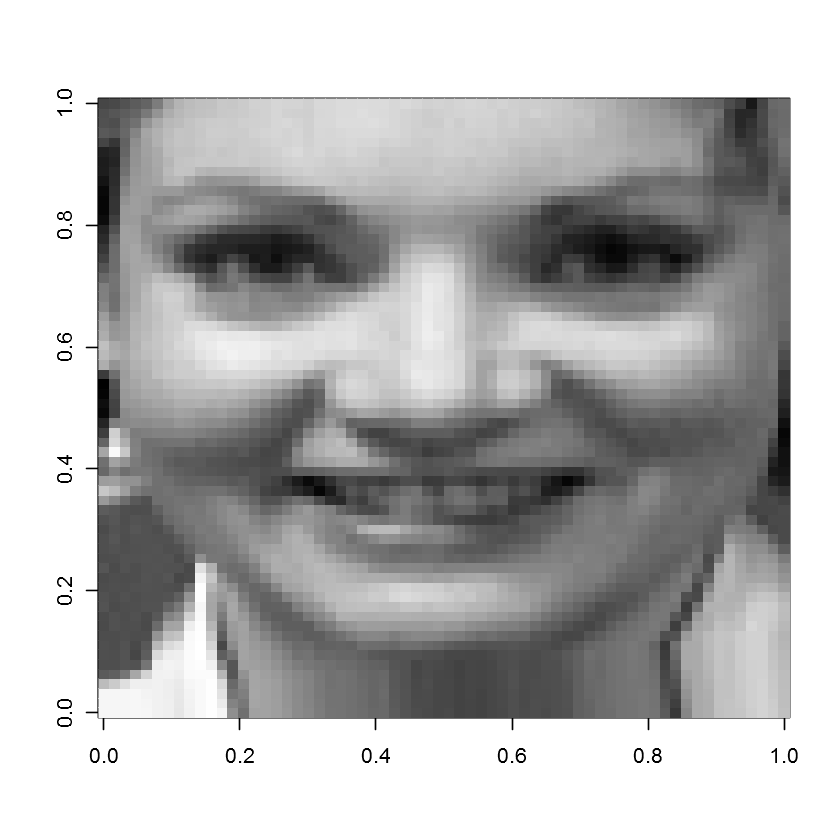

In [15]:
# Obtain the first pose of face 34.
img34_01 <- matrix(as.numeric(X_df[341, ]), nrow=64, byrow=T)
Show_img(img34_01)

At this point, you can compute the mean, the average, of the faces in the `X_df` dataset. Notice that each of the averages are of a single person. The example looks at persons 1, 2, 39, and 40. The output plots show the result of the averaging.

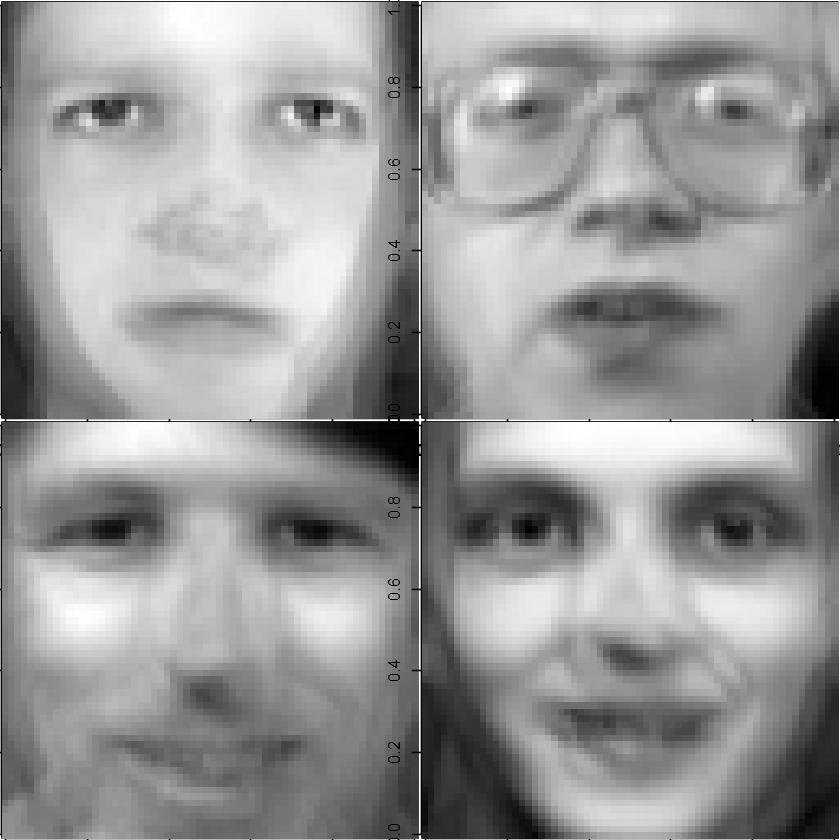

In [16]:
par(mfrow=c(2,2))
par(mar=c(0.1, 0.1, 0.1, 0.1))

AV1=colMeans(data.matrix(X_df[1:10,]))
Show_img(matrix(AV1, nrow=64,byrow=T))

AV2=colMeans(data.matrix(X_df[11:20,]))
Show_img(matrix(AV2, nrow=64,byrow=T))

AV39=colMeans(data.matrix(X_df[381:390,]))
Show_img(matrix(AV39, nrow=64,byrow=T))

AV40=colMeans(data.matrix(X_df[391:400,]))
Show_img(matrix(AV40, nrow=64,byrow=T))

## Performing Randomized Principle Component Analysis (PCA)

In [17]:
if (!require("rsvd")) {install.packages("rsvd")
                       library("rsvd")}

Loading required package: rsvd

Warning message:
"package 'rsvd' was built under R version 4.0.3"


In [18]:
# Shuffle the dataset so that the pictures are randomized.
set.seed(42)
rows <- sample(nrow(X_df))
shuffled <- X_df[rows, ]

# Train-test split
train <- shuffled[1:350, ]
train_labels <- y_df$V1[rows][1:350]
test <- shuffled[351:400, ]
test_labels <- y_df$V1[rows][351:400]

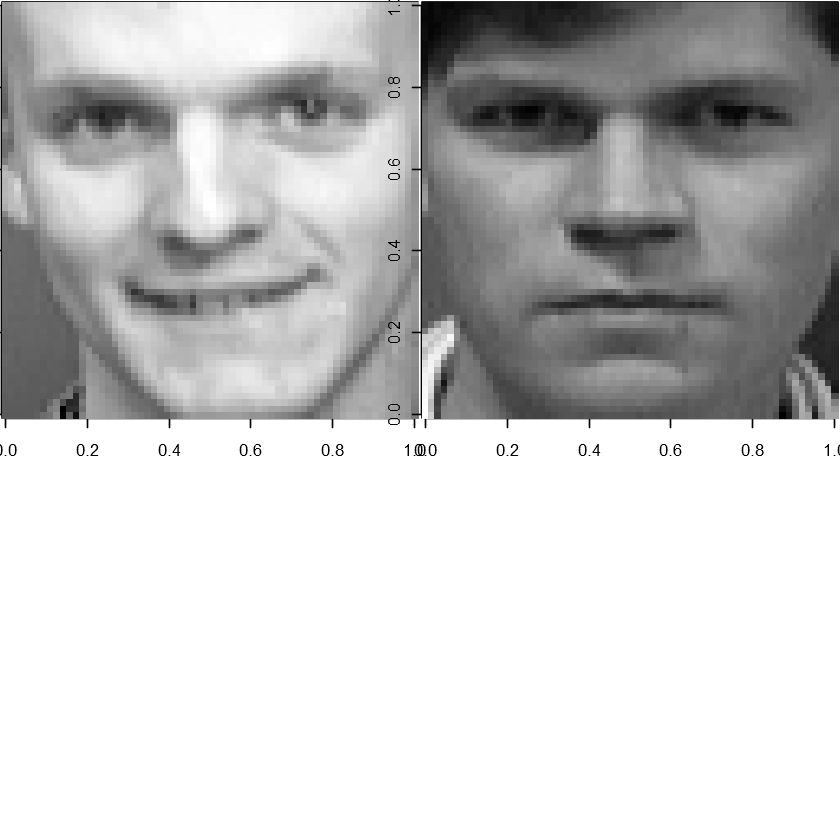

In [19]:
par(mfrow=c(2, 2))
par(mar=c(0.1, 0.1, 0.1, 0.1))

Show_img(matrix(as.numeric(train[1, ]), nrow=64, byrow=T))
Show_img(matrix(as.numeric(train[2, ]), nrow=64, byrow=T))

In [20]:
pca <- rpca(as.matrix(train))
summary(pca)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC341,PC342,PC343,PC344,PC345,PC346,PC347,PC348,PC349,PC350
Explained variance,1078.679,516.500,329.327,189.186,139.723,127.604,99.016,84.916,77.593,67.223,...,0.150,0.148,0.143,0.134,0.128,0.121,0.116,0.110,0.086,0
Standard deviations,32.843,22.727,18.147,13.754,11.820,11.296,9.951,9.215,8.809,8.199,...,0.387,0.385,0.378,0.365,0.358,0.348,0.340,0.332,0.293,0
Proportion of variance,0.263,0.126,0.080,0.046,0.034,0.031,0.024,0.021,0.019,0.016,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0
Cumulative proportion,0.263,0.389,0.470,0.516,0.550,0.581,0.605,0.626,0.645,0.662,...,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1


In [21]:
reduced_dims <- 32
summary(pca)[,reduced_dims]

Explained variance    Standard deviations Proportion of variance 
                16.153                  4.019                  0.004 
 Cumulative proportion 
                 0.828

In [22]:
compressed_train_faces <- predict(pca, as.matrix(train))[,1:reduced_dims]
compressed_test_faces  <- predict(pca, as.matrix(test))[,1:reduced_dims]

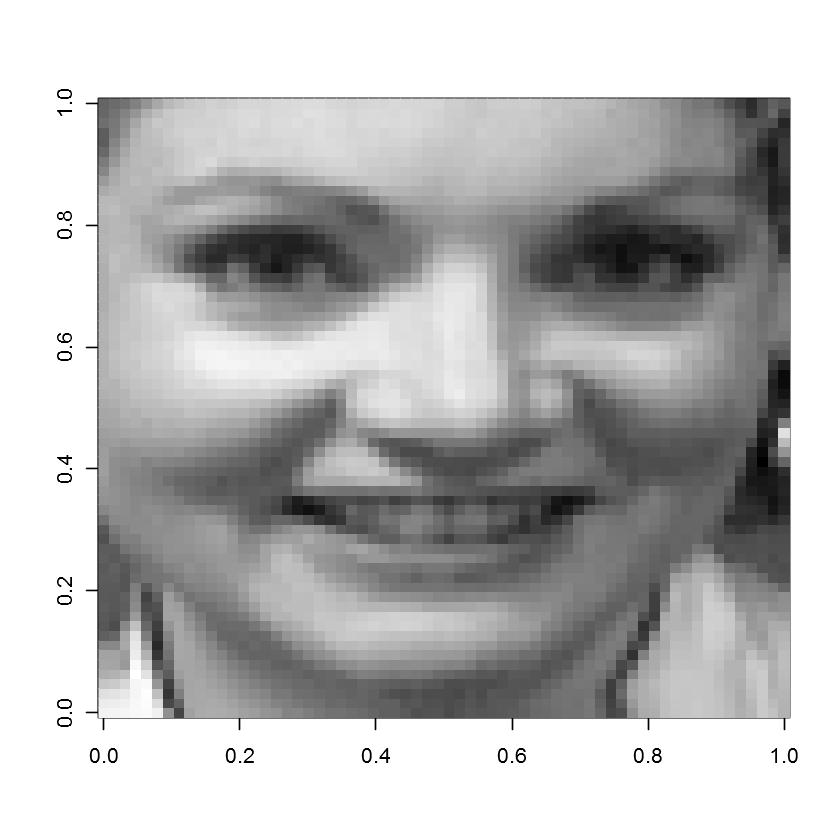

In [23]:
photo <- 12
Show_img(matrix(as.numeric(test[photo,]), nrow=64, byrow=T))

In [24]:
mask <- as.matrix(compressed_test_faces[photo,])

In [25]:
squared_errors <- as.numeric(rowSums(sweep(compressed_train_faces, 2, mask)^2))

In [26]:
# We order the errors from the least to the largest
error_rank <- order(as.numeric(squared_errors))

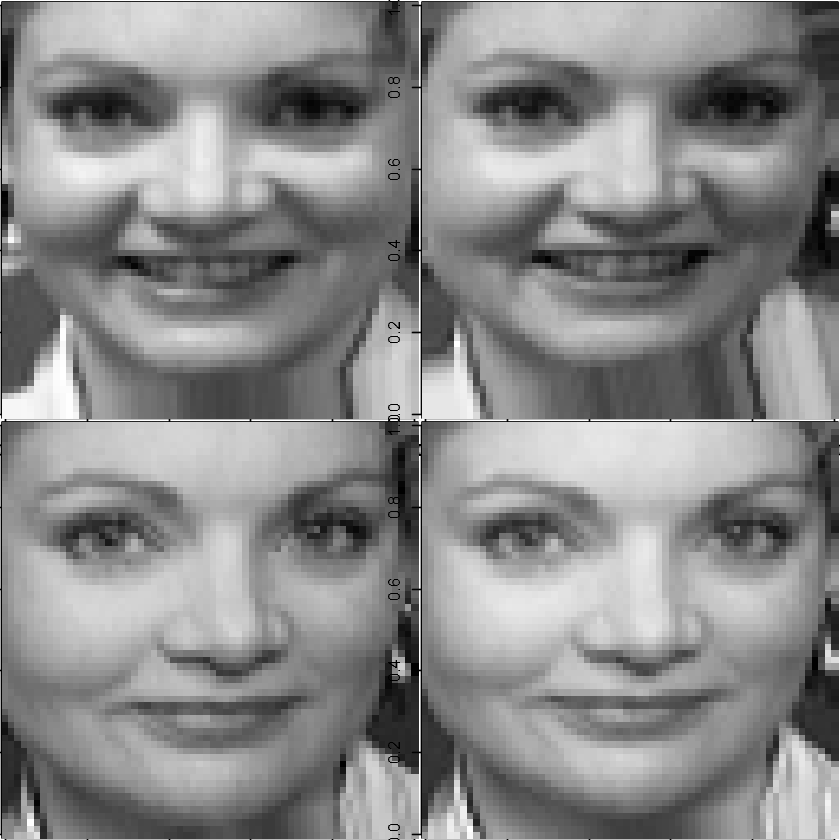

In [27]:
par(mfrow=c(2, 2))
par(mar=c(0.1, 0.1, 0.1, 0.1))

Show_img(matrix(as.numeric(train[error_rank[1],]), nrow=64, byrow=T))
Show_img(matrix(as.numeric(train[error_rank[2],]), nrow=64, byrow=T))
Show_img(matrix(as.numeric(train[error_rank[3],]), nrow=64, byrow=T))
Show_img(matrix(as.numeric(train[error_rank[4],]), nrow=64, byrow=T))

## Classifying Images

In [28]:
# installing feather library, if not yet available
if (!("feather" %in% rownames(installed.packages()))) {
    install.packages("feather")
}

if (!("RCurl" %in% rownames(installed.packages()))) {
    install.packages("RCurl")
}

library(feather)
library(RCurl)

In [29]:
url <- "https://github.com/lmassaron/datasets/releases/download/1.0/lfw_people.feather"
destfile <- "lfw_people.feather"
download.file(url, destfile, mode =  "wb")

lfw_people <- read_feather(destfile)

In [30]:
X <- as.matrix(lfw_people[ ,2:ncol(lfw_people)])
y <- as.factor(lfw_people[ ,1]$target)

[1] Junichiro Koizumi
8 Levels: Ariel Sharon Colin Powell Donald Rumsfeld ... Tony Blair


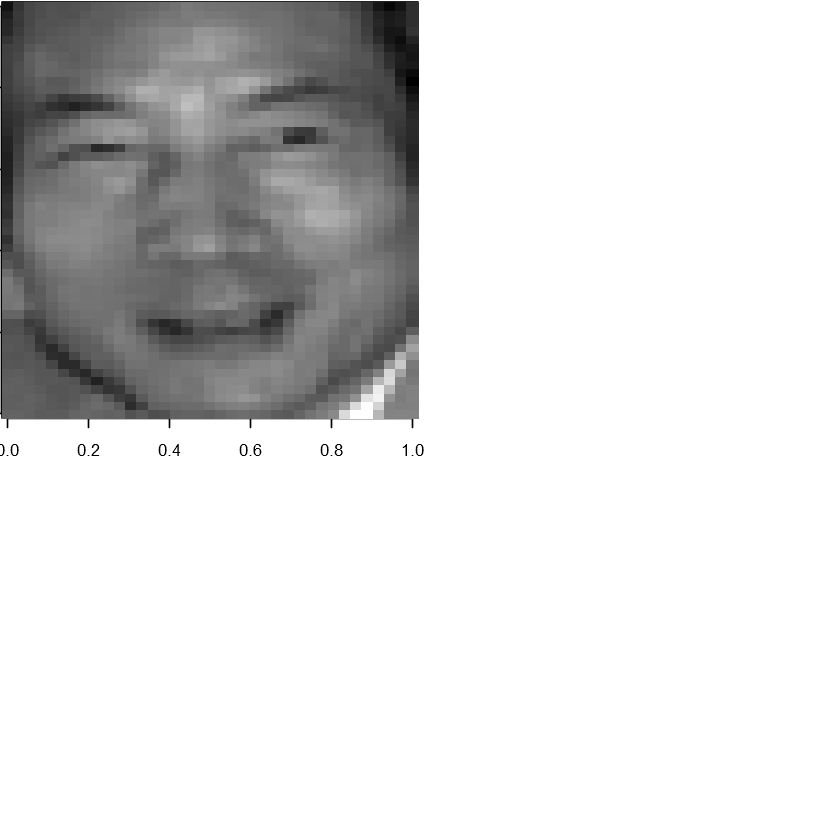

In [31]:
par(mfrow=c(2, 2))
par(mar=c(0.1, 0.1, 0.1, 0.1))
Show_img(matrix(X[7, ], nrow=50, ncol=37, byrow=T))
print(y[7])

In [32]:
# Shuffle the dataset so that the pictures are randomized.
set.seed(42)
rows <- sample(nrow(X))

In [33]:
X_train <- X[rows[1:1078], ]
y_train <- y[rows[1:1078]]
X_test <- X[rows[1078:nrow(X)], ]
y_test <- y[rows[1078:nrow(X)]]

In [34]:
pca <- rpca(as.matrix(X_train))

In [35]:
components <- 64
pca_train <- predict(pca, as.matrix(X_train))[ ,1:components]
pca_test <- predict(pca, as.matrix(X_test))[ ,1:components]

In [36]:
# installing caret library, if not yet available
if (!("caret" %in% rownames(installed.packages()))) {
    install.packages("caret")
}

# installing kernlab library, if not yet available
if (!("kernlab" %in% rownames(installed.packages()))) {
    install.packages("kernlab")
}

# installing e1071 library, if not yet available
if (!("e1071" %in% rownames(installed.packages()))) {
    install.packages("e1071")
} 

# installing MLmetrics library, if not yet available
if (!("MLmetrics" %in% rownames(installed.packages()))) {
    install.packages("MLmetrics")
} 

# installing doParallel library, if not yet available
if (!("doParallel" %in% rownames(installed.packages()))) {
    install.packages("doParallel")
} 

In [37]:
# Speeding up the cross-validation by setting parallel operations
library(doParallel)
cl <- makePSOCKcluster(3) # we set the number of parallel works in respect to the number of CV folds
registerDoParallel(cl)

Loading required package: foreach

Loading required package: iterators

Loading required package: parallel



In [38]:
library(caret)
set.seed(42)

ctrl <- trainControl(method="cv", 
                     number=3,
                     summaryFunction=multiClassSummary,
                     classProbs=FALSE)

# Define ranges for the two parameters
C_range <-     sapply(seq(-1.5, 2, 0.5), function(x){10^x})
sigma_range <- sapply(seq(-3, -2, 0.5), function(x){10^x})
                     
grid <- expand.grid(sigma = sigma_range,
                    C = C_range
)

svm_model<-train(as.matrix(pca_train), y_train,
                 method = "svmRadial", 
                 metric="Accuracy",
                 preProc = c("center", "scale"), 
                 trControl=ctrl,
                 tuneGrid = grid,
                 allowParallel=TRUE)

Loading required package: lattice

Loading required package: ggplot2

Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


In [39]:
print(svm_model)

Support Vector Machines with Radial Basis Function Kernel 

1078 samples
  64 predictor
   8 classes: 'Ariel Sharon', 'Colin Powell', 'Donald Rumsfeld', 'George W Bush', 'Gerhard Schroeder', 'Hugo Chavez', 'Junichiro Koizumi', 'Tony Blair' 

Pre-processing: centered (64), scaled (64) 
Resampling: Cross-Validated (3 fold) 
Summary of sample sizes: 719, 719, 718 
Resampling results across tuning parameters:

  sigma        C             Accuracy   Kappa       Mean_F1    Mean_Sensitivity
  0.001000000    0.03162278  0.3914681  0.00000000        NaN  0.1250000       
  0.001000000    0.10000000  0.3914681  0.00000000        NaN  0.1250000       
  0.001000000    0.31622777  0.3914681  0.00000000        NaN  0.1250000       
  0.001000000    1.00000000  0.4591948  0.13373410        NaN  0.1722334       
  0.001000000    3.16227766  0.7282137  0.62197316  0.6344783  0.5582159       
  0.001000000   10.00000000  0.8116734  0.75191198  0.7728593  0.7318733       
  0.001000000   31.62277660  0

In [40]:
preds <- predict(svm_model, newdata=as.matrix(pca_test), type = "raw")

In [41]:
library(MLmetrics)
ConfusionMatrix(y_pred=preds, y_true=y_test)


Attaching package: 'MLmetrics'


The following objects are masked from 'package:caret':

    MAE, RMSE


The following object is masked from 'package:base':

    Recall




                   y_pred
y_true              Ariel Sharon Colin Powell Donald Rumsfeld George W Bush
  Ariel Sharon                 8            0               1             1
  Colin Powell                 0           37               1             3
  Donald Rumsfeld              0            0              26             3
  George W Bush                0            2               4           101
  Gerhard Schroeder            0            0               1             2
  Hugo Chavez                  0            1               0             3
  Junichiro Koizumi            0            0               0             1
  Tony Blair                   0            2               0             2
                   y_pred
y_true              Gerhard Schroeder Hugo Chavez Junichiro Koizumi Tony Blair
  Ariel Sharon                      0           0                 0          0
  Colin Powell                      0           0                 0          0
  Donald Rumsfeld          

In [42]:
cat("Accuracy:", Accuracy(y_pred=preds, y_true=y_test))

Accuracy: 0.8671587